<a href="https://colab.research.google.com/github/Yayunyun/IDS705_final_project/blob/main/EDA_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up
- connect to google drive and load images to Colab
- import pacakges

In [ ]:
# @title import module and load data from google drive
# connect to google drive
from google.colab import drive
drive.mount('/content/drive/', force_remount = False)
# cd to my final project folder
%cd /content/drive/Othercomputers/My_MacBook_Pro/final_project/data
# move to working folder in colab
%cd /content
%mkdir final_project
%cd final_project

# unzip folder from google drive to colab
!unzip /content/drive/Othercomputers/My_MacBook_Pro/final_project/data/images.zip
#!unzip /content/drive/Othercomputers/My_MacBook_Pro/final_project/data/images2.zip
#!unzip /content/drive/Othercomputers/My_MacBook_Pro/final_project/data/images3.zip
!unzip /content/drive/Othercomputers/My_MacBook_Pro/final_project/data/images4.zip
!unzip /content/drive/Othercomputers/My_MacBook_Pro/final_project/data/images5.zip
!unzip /content/drive/Othercomputers/My_MacBook_Pro/final_project/data/images6.zip
!unzip /content/drive/Othercomputers/My_MacBook_Pro/final_project/data/images7.zip
#!unzip /content/drive/Othercomputers/My_MacBook_Pro/final_project/data/images8.zip
!unzip /content/drive/Othercomputers/My_MacBook_Pro/final_project/data/images9.zip
!unzip /content/drive/Othercomputers/My_MacBook_Pro/final_project/data/images10.zip
!unzip /content/drive/Othercomputers/My_MacBook_Pro/final_project/data/images11.zip
!unzip /content/drive/Othercomputers/My_MacBook_Pro/final_project/data/images12.zip

# copy files from g-drive to colab
%cp /content/drive/Othercomputers/My_MacBook_Pro/final_project/data/Data_Entry_2017.csv .
# import pacakges
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from PIL import Image

import matplotlib.pyplot as plt
import time
import os
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import os
import pandas as pd
from torchvision.io import read_image
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

%matplotlib inline
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

### OpenMP issues
os.environ['KMP_DUPLICATE_LIB_OK']='True'

%cd /content

# EDA and data preprocessing

In [ ]:
# load csv dataset from data folder
df = pd.read_csv('./final_project/Data_Entry_2017.csv')
# check how many observation and features
print("There are {} observations and {} features in the dataset".format(df.shape[0], df.shape[1]))
# check the first 5 rows
df.head(3)

There are 112120 observations and 12 features in the dataset


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN


In [ ]:
#drop the "Unanamed: 11" column
df.drop(columns = ['Unnamed: 11'], inplace = True)
# check missing value
df.isnull().sum()

Image Index                    0
Finding Labels                 0
Follow-up #                    0
Patient ID                     0
Patient Age                    0
Patient Gender                 0
View Position                  0
OriginalImage[Width            0
Height]                        0
OriginalImagePixelSpacing[x    0
y]                             0
dtype: int64

There is no missing value in the dataset. 

Merge image path and the information dataframe

In [ ]:
# merge image path and the dataframe
# load image paths
from glob import glob
image_paths = glob('./final_project/images*/*.png')
print(f'Total image files found : {len(image_paths)}')

# merge image path and the dataframe
Index =[]
for path in image_paths:
    Index.append(path.split('/')[3])
index_path_map = pd.DataFrame({'Index':Index, 'FilePath': image_paths})
index_path_map.head()

# rename "Image Index" column to "Index"
df.rename(columns={'Image Index':'Index'}, inplace=True)

# # Merge the absolute path of the images to the main dataframe
path_df = pd.merge(df, index_path_map, on='Index', how='inner')
path_df.head(3)

Total image files found : 112120


,Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],FilePath
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,./final_project/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,./final_project/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,./final_project/images/00000001_002.png


There are in total 112120 images.

Since our task is a binary classification task to see if a image has eithter at least one clinical finding or no finding, we relabel all images into either Sick = 1 or Sick = 0.

In [ ]:
# relabel all images into  Sick(==1) and Non-sic(==0)
path_df['Sick'] = path_df['Finding Labels'].map(lambda x: 0 if x == 'No Finding' else 1)
heart_df = path_df.copy()
heart_df.loc[heart_df['Patient Gender'] == 'M', 'Sick'].value_counts().sort_index()

0    33922
1    29418
Name: Sick, dtype: int64

The distribution of genders across classes of the original dataset.

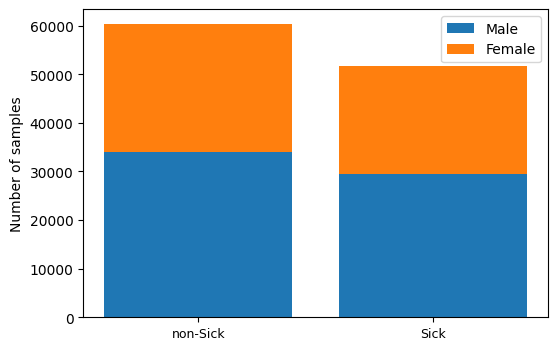

In [ ]:
# plot the distribution of gender across class in the original dataset
plt.figure(figsize=(6,4))
male_findings = heart_df.loc[heart_df['Patient Gender'] == 'M', 'Sick'].value_counts().sort_index()
female_findings = heart_df.loc[heart_df['Patient Gender'] == 'F', 'Sick'].value_counts().sort_index()
plt.bar(male_findings.index, male_findings.values, label = 'Male')
plt.bar(female_findings.index, female_findings.values, bottom=male_findings.values, label = 'Female')
plt.legend()
plt.ylabel('Number of samples')
plt.xticks([0,1], ['non-Sick', 'Sick'], size = 9);

# Create train, validation and test sets
Because of **limited computational resources and time**, we would only use 25K out of the original 110K samples.

In [ ]:
# create a indicator for gender where 1 = Male 0 = female
heart_df['gender'] = heart_df['Patient Gender'].map(lambda x: 1 if x=='M' else 0)
# sample 25000 samples from the original dataset
heart_df = heart_df.sample(25000, random_state = 0)

# Introduce Bias - create a balanced and a gender-imbalanced training set

We would create these 2 training sets to train our Unbiased and Biased model, respectively. 
- Create a balanced dataset with regard to class
- Train-test split with 80-20% ratio
- Make different gender-imabalanced train sets where 
  - sick-male:sick-female = 50:50 and 80:20.
- save these dataset for further training
- Split the imbalanced train set to train and validation set with 80-20% ratio.

  
By doing this, we are able to train the **Unbiased model** on the 50:50 training set and **Biased model** on the 80:20 training set. After training, we would evaluate the model's performacne and bias with same sets of test sets using our fairness metric. To make our fairness metrics comparable, we have several assumption.

## Assumption:  
  
For the training and validation dataset:
1. Number of **Sick male** = Number of **non-sick male** 
2. Number of **non-sick male** = Number of **non-sick female**

 
**Cons**:  
As we decrease the ratio of sick-female/non-sick-female, the model may become towards to predict non-sickness since the overall sick samples decrease. **However** since, we are not directly compare overall false negative rate(FNR) across dataset, we are comparing the fairness metric, which is somehow the ratio between gender-weighted FNR, this metric should be comarapble if we test the two models on the same test set.


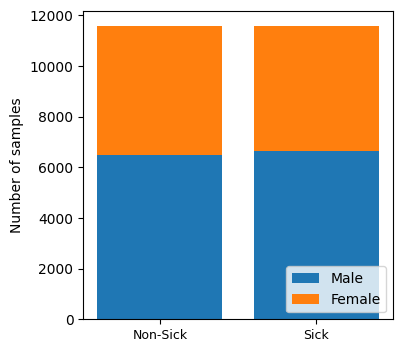

In [ ]:
# create a class-balanced(not gender balance) dataset
non_heart = heart_df.loc[heart_df['Sick'] == 0].sample(heart_df['Sick'].sum(), random_state = 1)
balanced_df = pd.concat([heart_df.loc[heart_df['Sick'] == 1], non_heart])

plt.figure(figsize=(4,4))
male_findings = balanced_df.loc[balanced_df['Patient Gender'] == 'M', 'Sick'].value_counts().sort_index()
female_findings = balanced_df.loc[balanced_df['Patient Gender'] == 'F', 'Sick'].value_counts().sort_index()
plt.bar(male_findings.index, male_findings.values, label = 'Male')
plt.bar(female_findings.index, female_findings.values, bottom=male_findings.values, label = 'Female')
plt.legend(loc = 'lower right')
plt.ylabel('Number of samples')
plt.xticks([0,1], ['Non-Sick', 'Sick'], size = 9);

- Split the class-balanced dataset into train and test with 80:20 ratio. 
- Create different levels of geneder-imbalanced training sets

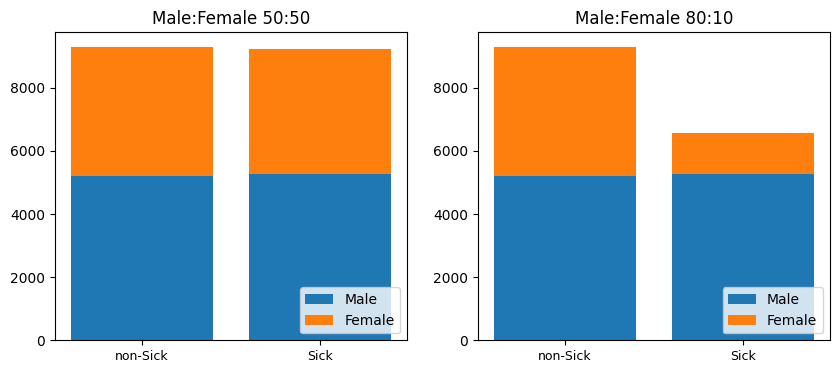

In [ ]:
# split the dataset into train and test
train_df_, test_df_ = train_test_split(balanced_df, test_size=0.2, random_state=2)

# make imbalanced train sets
def create_by_ratio(ratio, train_df):

  """function to create gender-imablanced training set
  ratio: female:male ratio
  train_df: dataframe to use"""

  # make an imbalanced dataset by undersampling female class
  train_male = train_df[train_df['Patient Gender'] == 'M']
  train_female = train_df[train_df['Patient Gender'] == 'F']
  # heart ==1
  male_sample_num = train_male[train_male['Sick'] == 1].shape[0]
  female_sample_num = np.round(male_sample_num*ratio).astype(int)
  female_df1 = train_female[train_female['Sick'] == 1].sample(female_sample_num,  random_state = 1)


  df_imbalanced = pd.concat([train_male, female_df1])
  df_imbalanced = pd.concat([df_imbalanced, train_female[train_female['Sick'] == 0]])

  return df_imbalanced

df_imbalanced_20_80 = create_by_ratio(20/80, train_df_)


list_labels = ['Male:Female 50:50', 'Male:Female 80:10']
list_train_imblanced = [train_df_, df_imbalanced_20_80]

# plot the distribution of hear disease related findings for different male:female ration dataset
plt.figure(figsize=(10,4))
for i in range(2):
  plt.subplot(1, 2, i+1)
  cur_df = list_train_imblanced[i]
  male_findings = cur_df.loc[cur_df['Patient Gender'] == 'M', 'Sick'].value_counts().sort_index()
  female_findings = cur_df.loc[cur_df['Patient Gender'] == 'F', 'Sick'].value_counts().sort_index()
  plt.bar(male_findings.index, male_findings.values, label = 'Male')
  plt.bar(female_findings.index, female_findings.values, bottom=male_findings.values, label = 'Female')
  plt.legend(loc = 'lower right')
  plt.title(list_labels[i])
  plt.xticks([0,1], ['non-Sick', 'Sick'], size = 9);


In [ ]:
# save the dataframe
train_df_.to_pickle('/content/drive/Othercomputers/My_MacBook_Pro/final_project/df50_50.pkl')
df_imbalanced_20_80.to_pickle('/content/drive/Othercomputers/My_MacBook_Pro/final_project/df20_80.pkl')
test_df_.to_pickle('/content/drive/Othercomputers/My_MacBook_Pro/final_project/df_test.pkl')